In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the two CSV files

home_data = pd.read_csv('./Data/Home_Data/combined_sensor_dataset_latest.csv')
# df2 = pd.read_csv('./Data/Prof_Office_Data/office_actuator_records.csv')

#original_df = df1.copy() #Keep a copy to compare
## Toggle the values of Light Sensor.
home_data.loc[home_data['sensor_name'] == 'Light Sensor', 'state'] = 1 - home_data['state']

# Change the continuous values to 1. We only need to check if the sensor is active or not
# home_data.loc[home_data['sensor_name'].isin(['Kitchen Humidity', 'Kitchen Temperature', 'Bedroom Humidity', 'Bedroom Temperature', 'Washroom Temperature', 'Washroom Humidity']), 'state'] = 1

# Convert the 'datetime' column to a datetime data type if necessary
home_data['datetime'] = pd.to_datetime(home_data['seconds'], unit='s')
# combined_office_data['datetime'] = pd.to_datetime(combined_office_data['date'] + ' ' + combined_office_data['time'], format='%d/%m/%y %H:%M')

# Sort by the 'datetime' column
home_data = home_data.sort_values(by='datetime')

filtered_home_data = home_data[~home_data['sensor_name'].isin(['Kitchen Humidity', 'Kitchen Temperature', 'Bedroom Humidity', 'Bedroom Temperature', 'Washroom Temperature', 'Washroom Humidity'])]


# Display the sorted, combined DataFrame
print(filtered_home_data.shape, home_data.shape)
unique_sensor = filtered_home_data.sensor_name.unique()
print(unique_sensor)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10176\498678440.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  home_data = pd.read_csv('./Data/Home_Data/combined_sensor_dataset_latest.csv')


(5645360, 9) (6289491, 9)
['Motion Inside Room(West Corner)' 'Entrance Motion' 'Entrance Door'
 'Motion Outside Room' 'Motion Inside Room(East Corner)' 'Room Door'
 'Closet Door' 'Closet Light' 'Desk Right Sonar' 'Desk Right Motion'
 'Desk Left Motion' 'Desk Left Sonar' 'Desk Left Light' 'Kitchen Light'
 'Kitchen Motion' 'Washroom Door' 'Washroom Motion' 'Bedroom Light']


In [18]:
filtered_home_data = filtered_home_data.set_index('datetime') #make the date column as index

# combined_office_data_filtered = combined_office_data.between_time('07:00', '19:00')
# print(combined_office_data.size, combined_office_data_filtered.size)
home_hourly = filtered_home_data.state.resample('4h').sum() #resample on hourly basis and get summary of sensor values on 2 hours.

# home_hourly = home_hourly.between_time('09:00', '18:00')
home_hourly = home_hourly.reset_index()
filtered_home_data = filtered_home_data.reset_index()

print(home_hourly.head, filtered_home_data.head(10))
# home_hourly.to_csv('./Output_CSV/home_data/test-sampling-1.csv', index=False)

<bound method NDFrame.head of                 datetime   state
0    2023-08-05 20:00:00     1.0
1    2023-08-06 00:00:00     3.0
2    2023-08-06 04:00:00     6.0
3    2023-08-06 08:00:00     0.0
4    2023-08-06 12:00:00     1.0
...                  ...     ...
1914 2024-06-19 20:00:00  2801.0
1915 2024-06-20 00:00:00  1683.0
1916 2024-06-20 04:00:00   288.0
1917 2024-06-20 08:00:00    60.0
1918 2024-06-20 12:00:00    41.0

[1919 rows x 2 columns]>                        datetime      date   time       seconds  state  \
0 2023-08-05 20:48:46.304768085  08/05/23  15:48  1.691269e+09    0.0   
1 2023-08-05 20:49:56.434901237  08/05/23  15:49  1.691269e+09    0.0   
2 2023-08-05 20:51:02.207592249  08/05/23  15:51  1.691269e+09    0.0   
3 2023-08-05 20:52:03.623199224  08/05/23  15:52  1.691269e+09    0.0   
4 2023-08-05 20:53:09.395964861  08/05/23  15:53  1.691269e+09    0.0   
5 2023-08-05 20:54:10.811565399  08/05/23  15:54  1.691269e+09    0.0   
6 2023-08-05 20:55:12.193258762  08/0

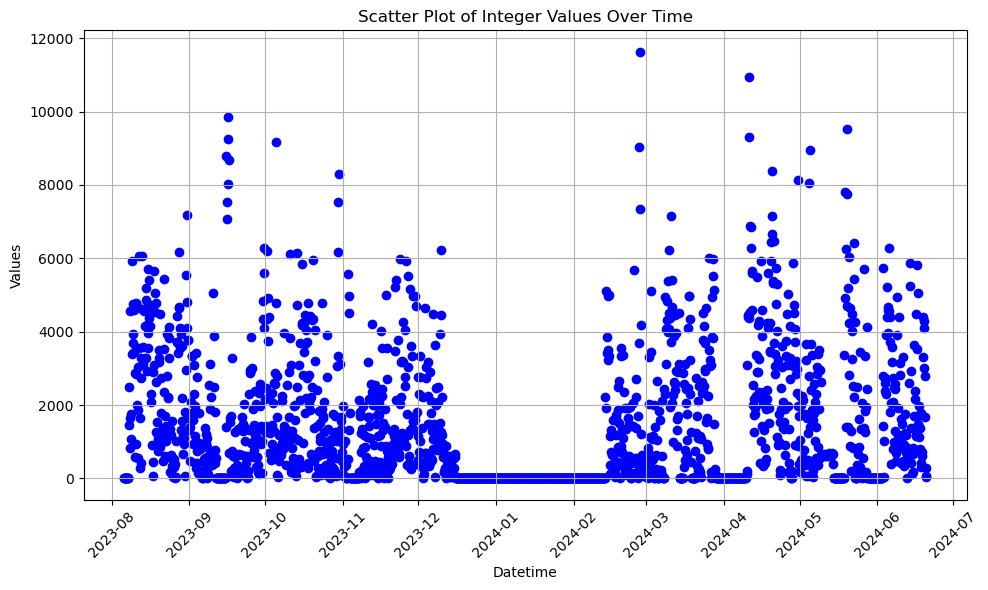

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(home_hourly['datetime'], home_hourly['state'], color='blue', marker='o')

# Formatting the plot
plt.title('Scatter Plot of Integer Values Over Time')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.grid(True)

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

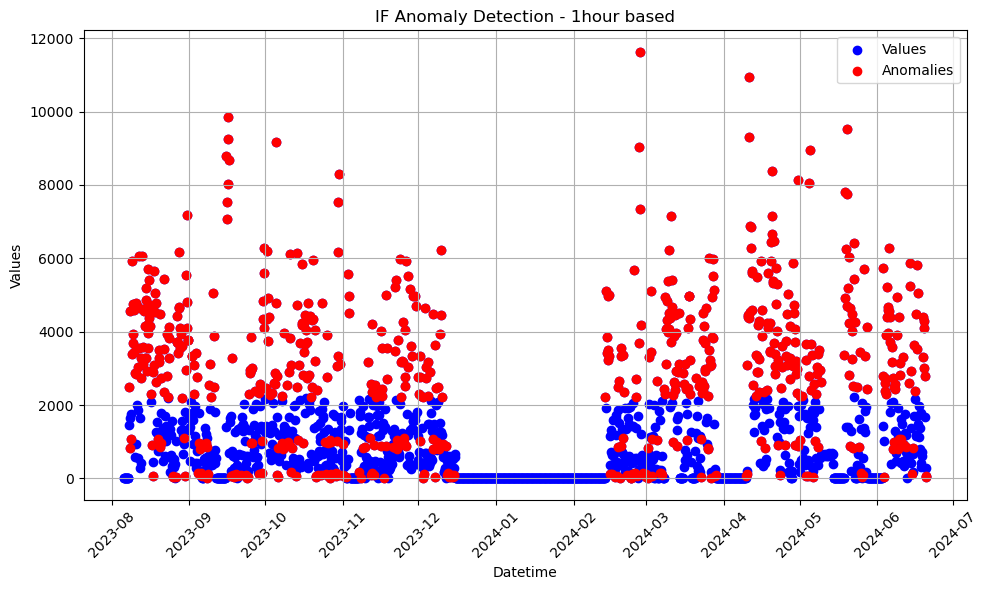

Total anomalies: 679, Percentage of anomalous values: 35.38301198540907%
                datetime   state  anomaly
0    2023-08-05 20:00:00     1.0        1
1    2023-08-06 00:00:00     3.0        1
2    2023-08-06 04:00:00     6.0        1
4    2023-08-06 12:00:00     1.0        1
8    2023-08-07 04:00:00     5.0        1
...                  ...     ...      ...
1906 2024-06-18 12:00:00  1793.0        1
1907 2024-06-18 16:00:00   707.0        1
1908 2024-06-18 20:00:00   607.0        1
1915 2024-06-20 00:00:00  1683.0        1
1916 2024-06-20 04:00:00   288.0        1

[720 rows x 3 columns]
(679, 3)


In [20]:
from sklearn.ensemble import IsolationForest

# lab_hourly['datetime'] = pd.to_datetime(lab_hourly['datetime'])

# Prepare data for IsolationForest
values = home_hourly[['state']]  # Selecting the 'values' column as input for the model

# Initialize and fit the IsolationForest model
model = IsolationForest(contamination='auto', random_state=42)
home_hourly['anomaly'] = model.fit_predict(values)

# Isolation Forest outputs:
# -1 for anomalies
#  1 for normal data points

# Filter the anomalies
anomalies = home_hourly[home_hourly['anomaly'] == -1]
non_anomalies = home_hourly[home_hourly['anomaly'] == 1]
# print(df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(home_hourly['datetime'], home_hourly['state'], label='Values', color='blue', marker='o')
plt.scatter(anomalies['datetime'], anomalies['state'], color='red', label='Anomalies', marker='o')
plt.title('IF Anomaly Detection - 1hour based')
plt.xlabel('Datetime')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
# plt.savefig('./Plots/Office_plots/IF_2H.png')
plt.show()


count_anomaly_h = (home_hourly['anomaly'] == -1).sum()

# Calculate the percentage of values equal to -1
percentage_h = (count_anomaly_h / len(home_hourly)) * 100
print(f"Total anomalies: {count_anomaly_h}, Percentage of anomalous values: {percentage_h}%")

#only print the non anomalous values which are not zero
df_filtered = non_anomalies[non_anomalies['state'] != 0]
print(df_filtered)

print( anomalies.shape)
# home_hourly.to_csv('./Output_CSV/home_data/IF_lab_anomaly_1h.csv', index=False)

In [ ]:
anomalies_date = anomalies.set_index('datetime')
anomalies_date_idx = anomalies_date.index


home_data = home_data.set_index('datetime')
# print(anomalies_date, home_data)

# Filtering out the hourly anomalous data from the original data
filtered_df = home_data[~home_data.index.floor('4h').isin(anomalies_date_idx)].reset_index()

print(filtered_df.shape)
# filtered_df.to_csv('./Output_CSV/home_data/test-filtered-1.csv', index=False)
    

(1738056, 9)


In [25]:
from sklearn.ensemble import IsolationForest

def anomaly_detection_and_removal(home, filtered_home, timeWindow = 'h'):
    filtered_home = filtered_home.set_index('datetime') #make the date column as index

    # combined_office_data_filtered = combined_office_data.between_time('07:00', '19:00')
    # print(combined_office_data.size, combined_office_data_filtered.size)
    filtered_home_hourly = filtered_home.state.resample(timeWindow).sum() #resample on hourly basis and get summary of sensor values on 2 hours.

    # df_hourly = df_hourly.between_time('09:00', '18:00')
    filtered_home_hourly = filtered_home_hourly.reset_index()
    
    values = filtered_home_hourly[['state']]  # Selecting the 'values' column as input for the model

    # Initialize and fit the IsolationForest model
    model = IsolationForest(contamination='auto', random_state=42)
    filtered_home_hourly['anomaly'] = model.fit_predict(values)

    # Isolation Forest outputs:
    # -1 for anomalies
    #  1 for normal data points

    # Filter the anomalies
    anomalies = filtered_home_hourly[filtered_home_hourly['anomaly'] == -1]
    # regular = df_hourly[df_hourly['anomaly'] == 1]
    

    regular_date = anomalies.set_index('datetime')
    regular_idx = regular_date.index
    # print(regular_idx)

    home = home.set_index('datetime')
    # Filtering out the hourly anomalous data from the original data
    # filtered_df = df[df.index.floor(timeWindow).isin(regular_idx)].reset_index()
    filtered_df = home[~home.index.floor(timeWindow).isin(regular_idx)].reset_index()

    return filtered_df

In [5]:
#FNE and TD implementations
from math import ceil
from sklearn.cluster import SpectralClustering
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from neighbor_group import *
from sklearn.manifold import SpectralEmbedding

def frequent_next_event(df, adjacency_matrix):
    prev_row = df.iloc[0]
    for _,cur_row in df.iterrows():
        if (cur_row.sensor_name != prev_row.sensor_name):
            t = max(ceil(cur_row.seconds - prev_row.seconds), 1.0)
            # t = max(ceil((cur_row.DateTime - prev_row.DateTime).total_seconds()),1.0)
            adjacency_matrix[prev_row.sensor_name][cur_row.sensor_name] += 1/t
        prev_row = cur_row
    
    return adjacency_matrix

def time_delta(df, adjacency_matrix, th=2):
    cur_group = []
    prev_row = df.iloc[0]
    for _, cur_row in df.iterrows():
        if ((cur_row.seconds - prev_row.seconds) >= th):
            cur_group = []
        if not(cur_row.sensor_name in cur_group):
            cur_group.append(cur_row.sensor_name)
        for item in cur_group:
            adjacency_matrix[item][cur_row.sensor_name] += 1
        prev_row = cur_row
    
    return adjacency_matrix


def get_sensor_groups(adjacency_matrix):
    # Fixed cluster number
    n = 3
    max_ch = 0
    stop_iter = 10
    cluster_score_dict = {}
    patience = 0

    spectral_clustering = SpectralClustering(n, affinity="precomputed")
    cluster = spectral_clustering.fit_predict(adjacency_matrix)
    embedding = SpectralEmbedding(n_components=2, affinity='precomputed')
        
    features = embedding.fit_transform(adjacency_matrix)

    ch_score = calinski_harabasz_score(features, cluster)
    silhouette_avg = silhouette_score(features, cluster)
    db_score = davies_bouldin_score(features, cluster)

    cluster_score_dict['cluster_number'] = n
    cluster_score_dict['ch-score'] = ch_score
    cluster_score_dict['silhoutte-score'] = silhouette_avg
    cluster_score_dict['db-score'] = db_score
    cluster_score_dict['cluster'] = cluster
    print(cluster_score_dict)

    cluster_dict = get_cluster_sensor_list(cluster_score_dict['cluster'], adjacency_matrix)
    adjacency_matrix_list, unique_sensors = get_adjacency_matrix_list(cluster_dict, adjacency_matrix)

    # Get groups based on fixed nearest nodes
    sensor_group = {}
    sensor_number_each_group = 3  # Select the sensor numbers that will used to pick top nearest nodes
    i = 1 
    for index, matrix in enumerate(adjacency_matrix_list):
        groups = get_groups(matrix, sensor_number_each_group, unique_sensors[index])
        for group in groups:
            item_list = []
            for item in group:
                item_list.append(item)
            sensor_group['G'+ str(i)] = item_list
            i += 1

    # sensor_group_df = pd.DataFrame(sensor_group)
    print(sensor_group)
    return cluster_score_dict

In [18]:
unique_sensor = home_data.sensor_name.unique()

fnq_adjacency_matrix = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)
td_adjacency_matrix = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)

print('Frequent next event starts')
print('---------------------------')
fnq_adjacency_matrix = frequent_next_event(home_data, fnq_adjacency_matrix)
print('---------------------------')
print('Frequent next event ends')

print('Time Delta starts')
print('---------------------------')
# td_adjacency_matrix = time_delta(home_data, td_adjacency_matrix)
print('---------------------------')
print('Time Delta ends')

fne_scores = get_sensor_groups(adjacency_matrix=fnq_adjacency_matrix)

print("~~~ Time Delta results ~~~")

# td_scores = get_sensor_groups(td_adjacency_matrix)

# FNE
#{'cluster_number': 2, 'ch-score': 22.25262816159003, 'silhoutte-score': 0.6379307129426132, 'db-score': 0.4079323384378, 'cluster': array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0, 1])}

#TD
#{'cluster_number': 2, 'ch-score': 23.354525308582886, 'silhoutte-score': 0.5507230369751293, 'db-score': 0.5885350572305312, 'cluster': array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 0])}

#FNE
#{'cluster_number': 3, 'ch-score': 62.2086134386679, 'silhoutte-score': 0.7269994505079088, 'db-score': 0.29789624746318877, 'cluster': array([0, 0, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    #    0, 1])}

#TD
# {'cluster_number': 3, 'ch-score': 50.57308549964048, 'silhoutte-score': 0.5893114768248414, 'db-score': 0.5028462040428648, 'cluster': array([0, 0, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
#        1, 2])}

Frequent next event starts
---------------------------


C:\Users\mt5864s\AppData\Local\Temp\ipykernel_21192\1819911794.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adjacency_matrix[prev_row.sensor_name][cur_row.sensor_name] += 1/t


---------------------------
Frequent next event ends
Time Delta starts
---------------------------
---------------------------
Time Delta ends
{'cluster_number': 3, 'ch-score': 62.20861343866787, 'silhoutte-score': 0.7269994505079085, 'db-score': 0.29789624746318927, 'cluster': array([0, 0, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1])}
['Kitchen Humidity', 'Kitchen Temperature', 'Entrance Motion', 'Entrance Door', 'Motion Outside Room', 'Motion Inside Room(East Corner)', 'Room Door', 'Closet Door', 'Closet Light', 'Desk Right Sonar', 'Desk Right Motion', 'Desk Left Motion', 'Desk Left Sonar', 'Desk Left Light', 'Kitchen Light', 'Kitchen Motion', 'Washroom Door', 'Washroom Motion']
['Bedroom Humidity', 'Motion Inside Room(West Corner)', 'Bedroom Temperature', 'Bedroom Light']
['Washroom Temperature', 'Washroom Humidity']
number of unique group  13
('Entrance Door', 'Entrance Motion', 'Kitchen Motion')
('Desk Left Motion', 'Desk Left Sonar', 'Desk Right Sonar

c:\Users\mt5864s\AppData\Local\miniconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
c:\Users\mt5864s\AppData\Local\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\mt5864s\AppData\Local\miniconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [26]:
unique_sensor = home_data.sensor_name.unique()

fnq_adjacency_matrix_filtered = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)
td_adjacency_matrix_filtered = pd.DataFrame(0.0, columns=unique_sensor, index=unique_sensor)

# filtered data after detecting and removing anomaly based on 1 hour data partition
fd = anomaly_detection_and_removal(home_data,filtered_home_data, '2h')
print('Frequent next event starts')
print('---------------------------')
fnq_adjacency_matrix_filtered = frequent_next_event(fd, fnq_adjacency_matrix_filtered)
print('---------------------------')
print('Frequent next event ends')

print('Time Delta starts')
print('---------------------------')
# td_adjacency_matrix_filtered = time_delta(fd, td_adjacency_matrix_filtered)
print('---------------------------')
print('Time Delta ends')

fne_scores_filtered = get_sensor_groups(adjacency_matrix=fnq_adjacency_matrix_filtered)

print("~~~ Time Delta results ~~~")

# td_scores_filtered = get_sensor_groups(td_adjacency_matrix_filtered)

KeyError: "None of ['datetime'] are in the columns"